# Phase 2: Feature Engineering

In this notebook we will:
1. Load interim datasets.  
2. Encode categorical variables.  
3. Extract date-based features.  
4. Scale numeric features (Standard & MinMax).  
5. Visualize before/after scaling.  
6. Feature Extraction: PCA & L1/L2.  
7. Save processed datasets.

### 1. Setup paths for interim & processed data
Define `DATA_INTERIM` for cleaned inputs and `DATA_PROCESSED` for final feature‐engineered outputs.

In [1]:
# Parameters cell for Papermill
DATA_INTERIM   = "data/interim"
DATA_PROCESSED = "data/processed"

In [2]:
# Parameters
DATA_INTERIM = "data/interim"
DATA_PROCESSED = "data/processed"


### 2. Imports & Plot Configuration
Load libs for scaling, PCA, imputation, and linear models; set plotting style.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition   import PCA
from sklearn.impute          import SimpleImputer
from sklearn.linear_model    import Lasso, Ridge

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

### 3. Load Interim CSVs
Read the cleaned interim files into DataFrames for transformation.

In [4]:
historical = pd.read_csv(f"{DATA_INTERIM}/historical_clean.csv", parse_dates=['date'])
coins      = pd.read_csv(f"{DATA_INTERIM}/coins_clean.csv")

### 4. One-Hot Encode Coin Attributes
Convert `status` and `category` in `coins` into indicator columns, dropping the first level to avoid collinearity.

In [5]:
coins_ohe = pd.get_dummies(coins, columns=['status','category'], drop_first=True)
# quick display to confirm
display(coins_ohe.filter(like='status_').head())
display(coins_ohe.filter(like='category_').head())

,status_extinct,status_inactive,status_untracked
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


,category_token
0,False
1,False
2,False
3,False
4,False


### 5. Extract Date Features
From the `date` column in `historical`, create numeric features: year, month, day, weekday.

In [6]:
historical['year']    = historical['date'].dt.year
historical['month']   = historical['date'].dt.month
historical['day']     = historical['date'].dt.day
historical['weekday'] = historical['date'].dt.weekday
display(historical[['date','year','month','day','weekday']].head())

,date,year,month,day,weekday
0,2013-04-28,2013,4,28,6
1,2013-04-28,2013,4,28,6
2,2013-04-28,2013,4,28,6
3,2013-04-28,2013,4,28,6
4,2013-04-28,2013,4,28,6


### 6. Scale Numeric Columns
Apply both StandardScaler (z-score) and MinMaxScaler to key columns, appending `_std` and `_mm`.

In [7]:
num_cols   = ['price','market_cap','volume_24h','percent_change_24h']
scaler_std = StandardScaler()
scaler_mm  = MinMaxScaler()

std_vals = scaler_std.fit_transform(historical[num_cols])
mm_vals  = scaler_mm.fit_transform(historical[num_cols])

hist_std = pd.DataFrame(std_vals, columns=[f"{c}_std" for c in num_cols])
hist_mm  = pd.DataFrame(mm_vals,  columns=[f"{c}_mm"  for c in num_cols])

historical = pd.concat([historical, hist_std, hist_mm], axis=1)

### 7. Visualize Distributions of Original vs Scaled
For each original and scaled column, sample up to 100 000 points, then plot histograms side-by-side.

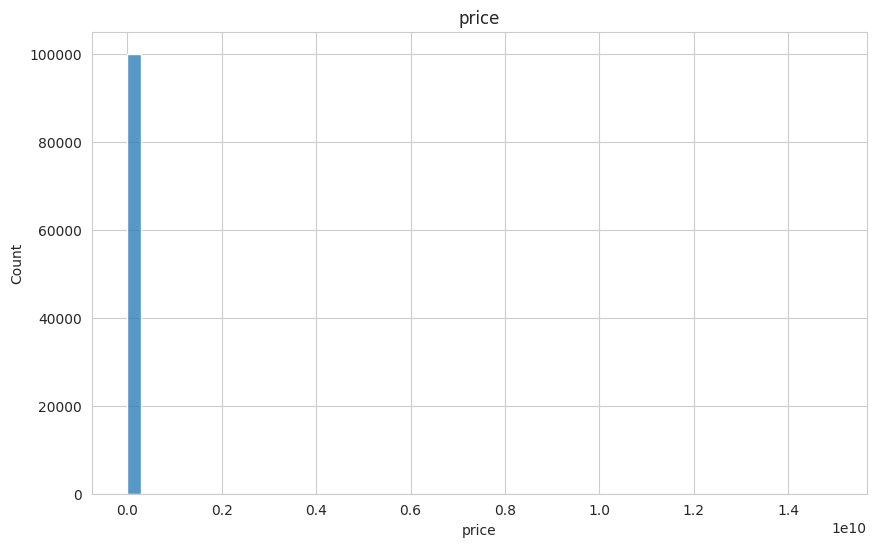

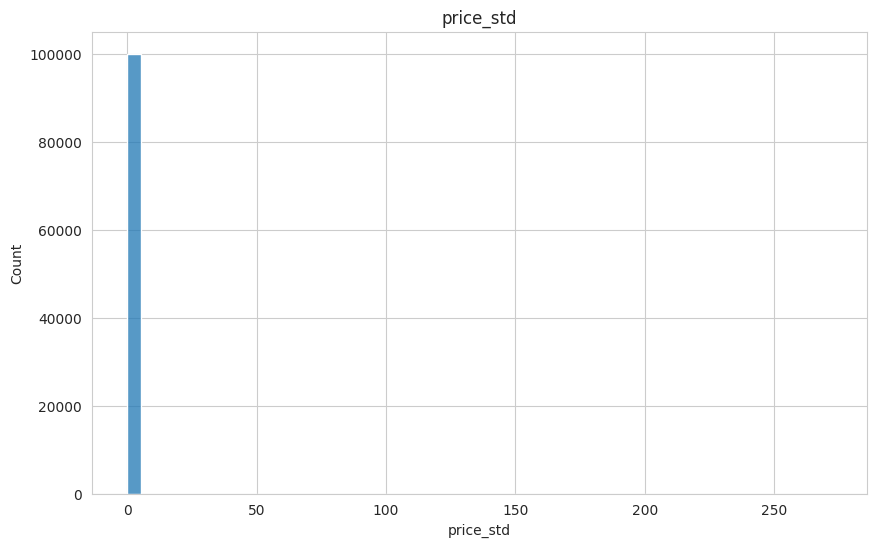

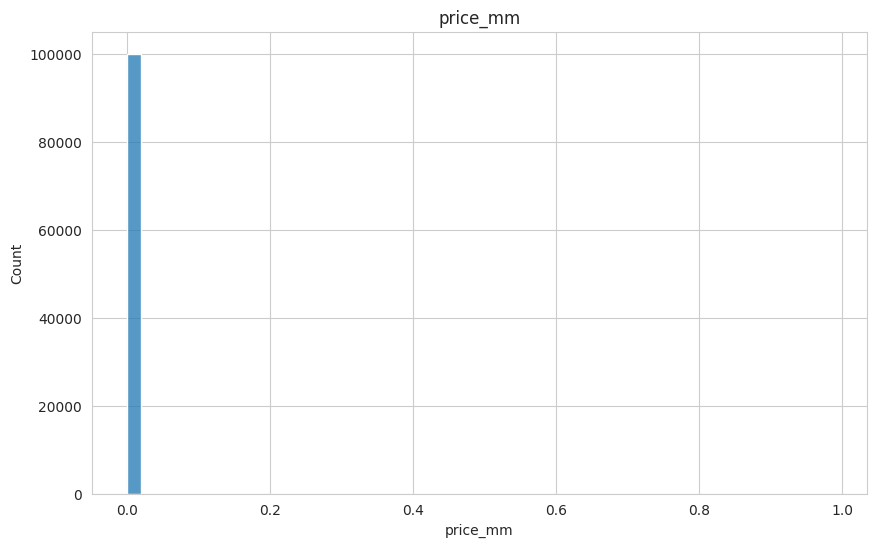

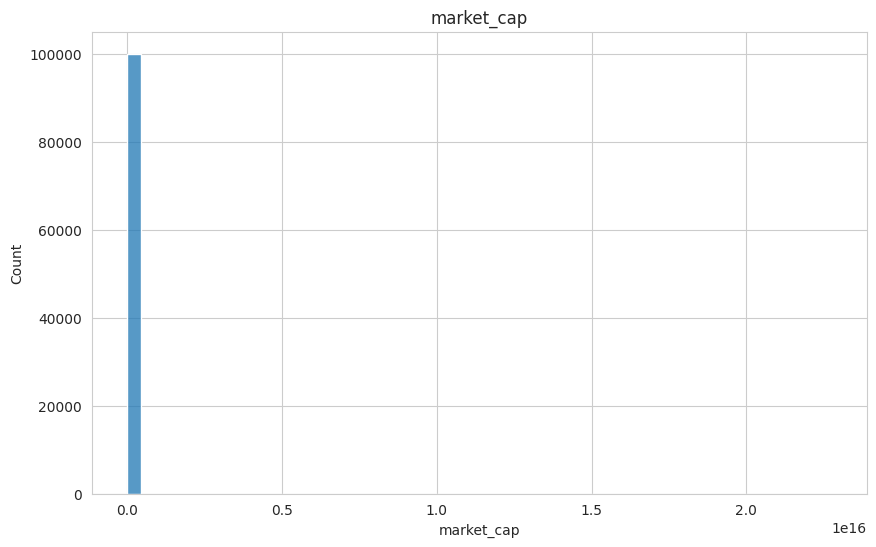

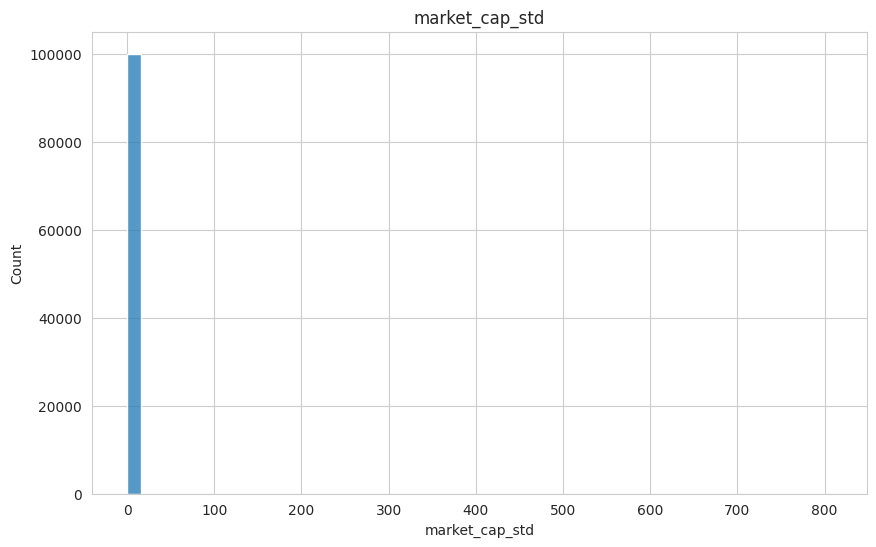

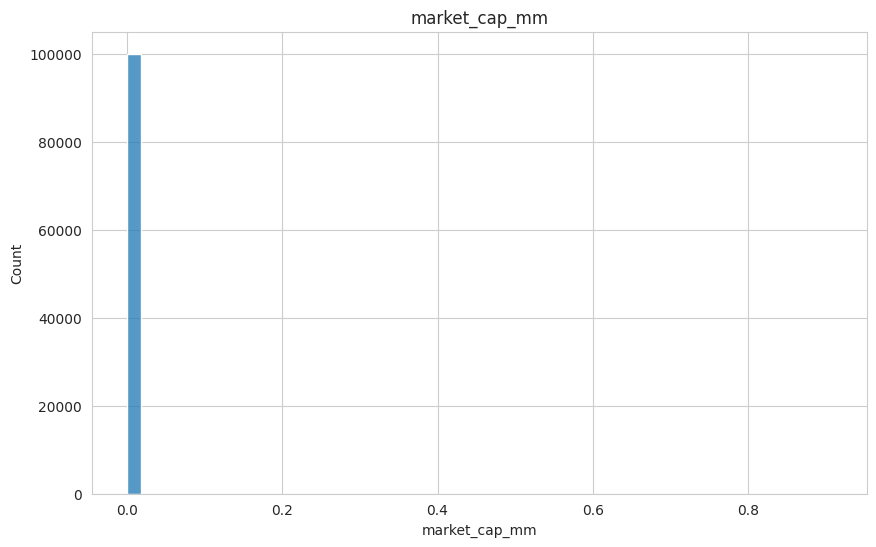

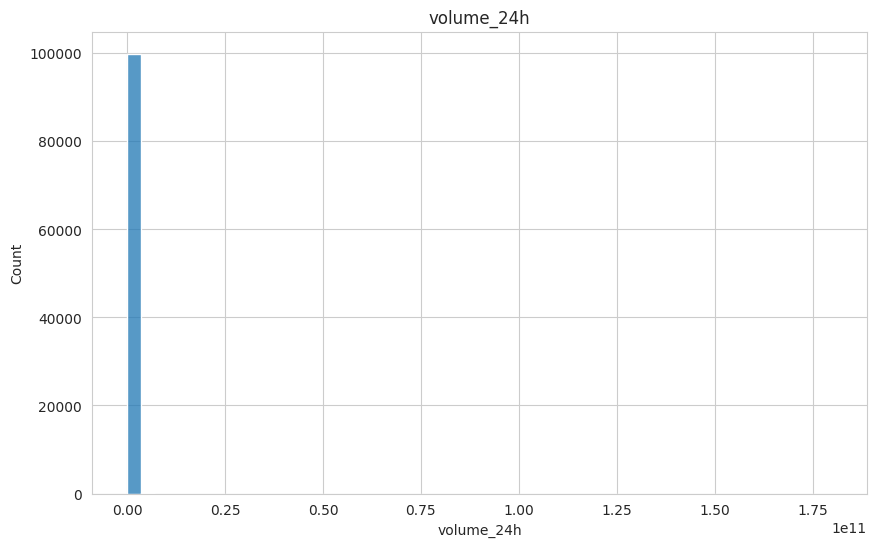

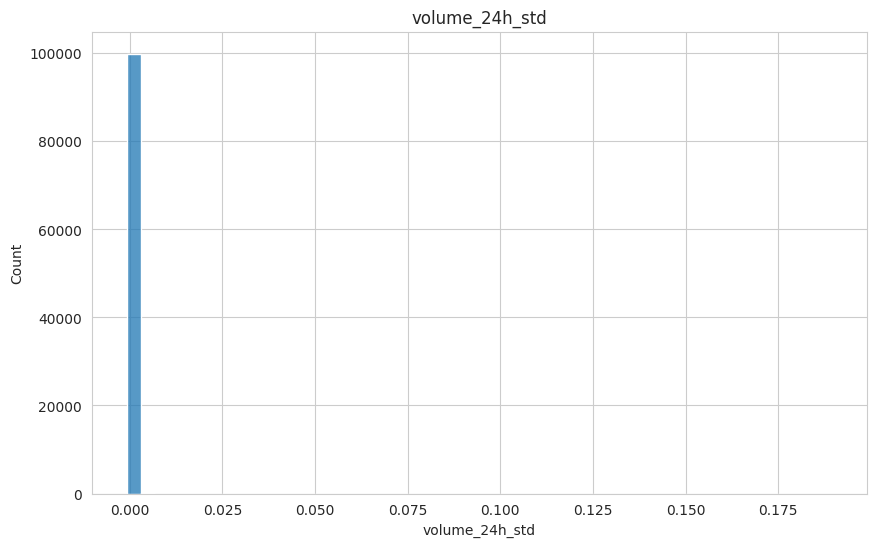

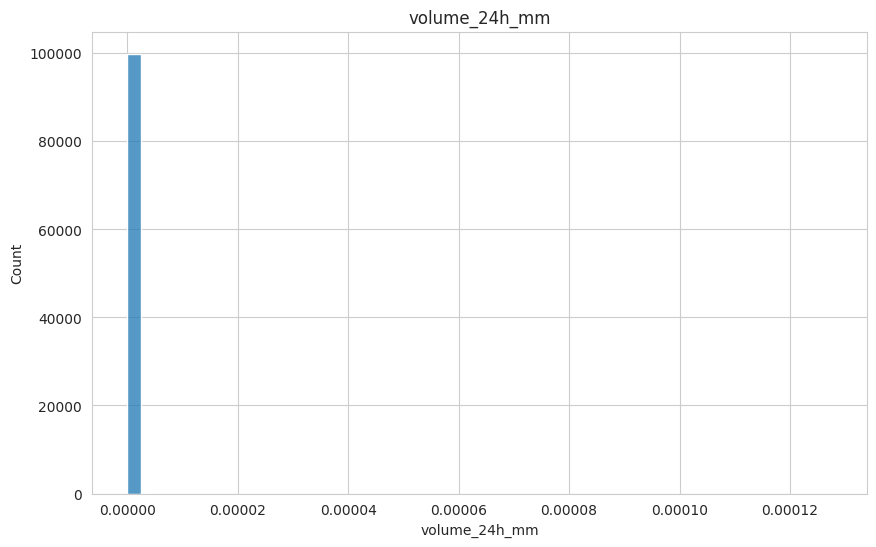

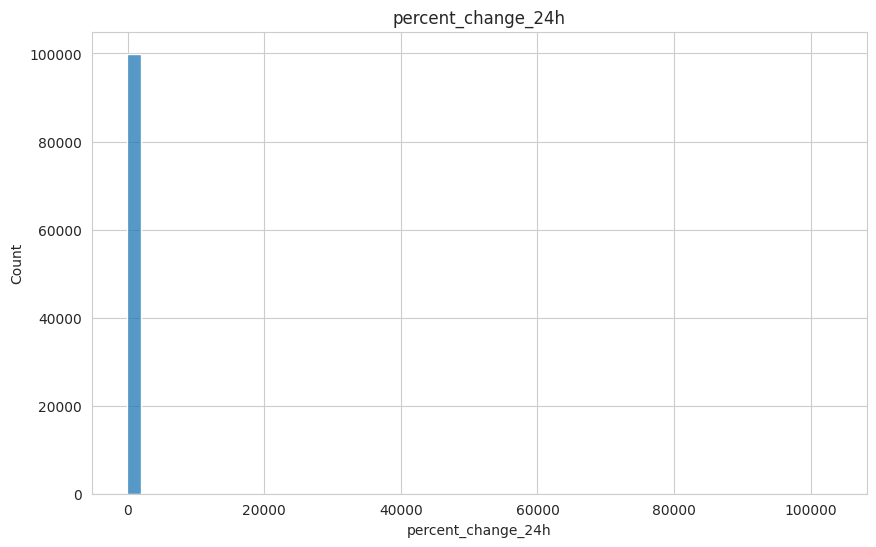

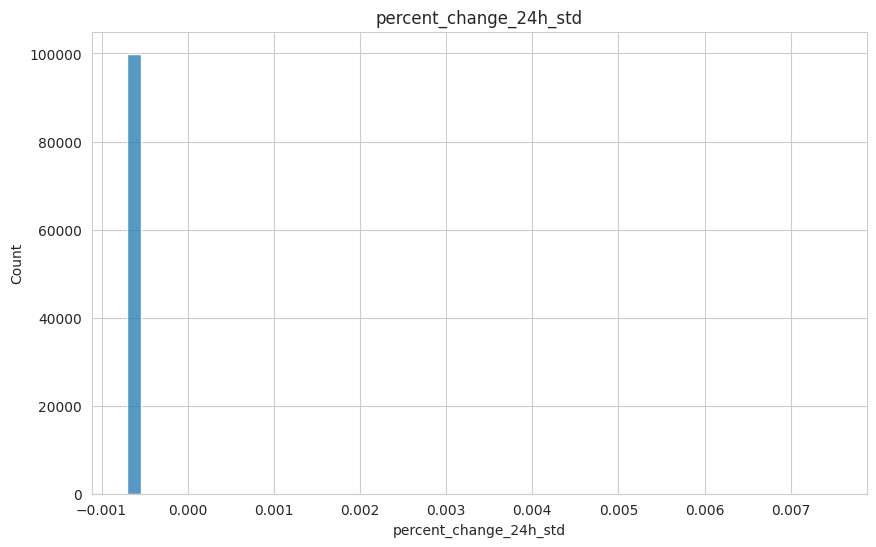

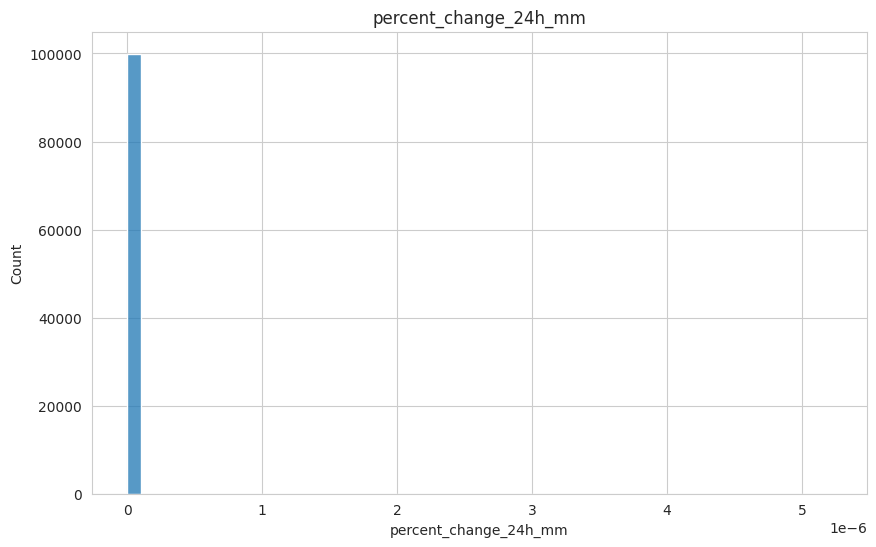

In [8]:
def subsample(s, n=100000):
    return s.sample(n, random_state=42) if len(s)>n else s

for orig in num_cols:
    std_col = f"{orig}_std"
    mm_col  = f"{orig}_mm"
    for col in (orig, std_col, mm_col):
        data = subsample(historical[col].dropna())
        sns.histplot(data, bins=50).set_title(col)
        plt.show()

### 8. PCA Variance & Component Selection
1. Impute any NaNs in scaled features.
2. Fit PCA and plot cumulative explained variance.
3. Determine how many components are needed for ≥90 % variance.

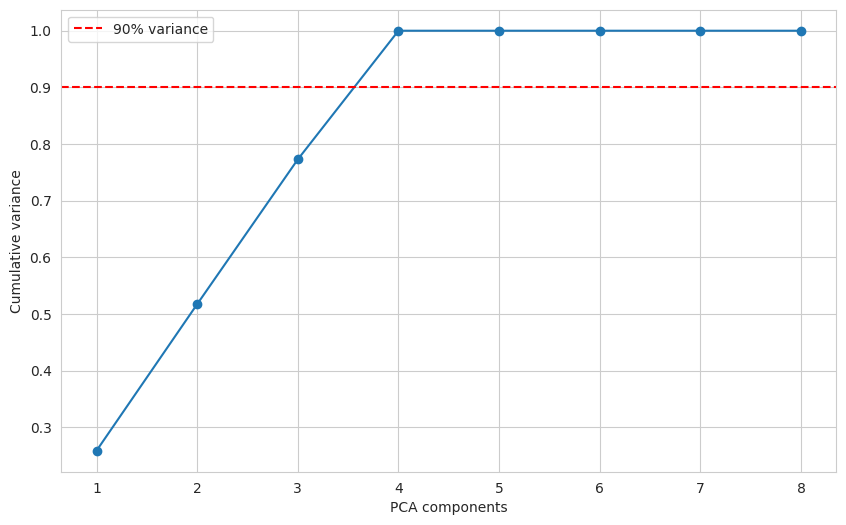

Components for 90% variance: 4


In [9]:
scaled_cols = [c for c in historical.columns if c.endswith(("_std","_mm"))]
imputer     = SimpleImputer(strategy='mean')
X_scaled    = imputer.fit_transform(historical[scaled_cols])

pca       = PCA()
pca.fit(X_scaled)
cum_var   = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% variance')
plt.xlabel("PCA components"); plt.ylabel("Cumulative variance")
plt.legend(); plt.show()

n_components_90 = np.searchsorted(cum_var, 0.90) + 1
print(f"Components for 90% variance: {n_components_90}")

### 9. Feature Selection via Lasso & Ridge
Fit Lasso and Ridge to predict `price` from all scaled features; rank by absolute L1 coefficient to find top 10 drivers.

In [10]:
X_fs = X_scaled
y_fs = historical['price'].values

lasso = Lasso(alpha=0.1, random_state=42).fit(X_fs, y_fs)
ridge = Ridge(alpha=1.0, random_state=42).fit(X_fs, y_fs)

coef_df = pd.DataFrame({
    'feature':    scaled_cols,
    'coef_lasso': lasso.coef_,
    'coef_ridge': ridge.coef_
}).set_index('feature')

coef_df['abs_lasso'] = coef_df['coef_lasso'].abs()
top10 = coef_df.sort_values('abs_lasso', ascending=False).head(10)
display(top10[['coef_lasso','coef_ridge']])

,coef_lasso,coef_ridge
feature,,
price_std,5.479095e+07,5.479022e+07
market_cap_std,-0.000000e+00,-3.713623e-08
volume_24h_std,-0.000000e+00,-3.433275e-05
percent_change_24h_std,-0.000000e+00,-3.541026e-05
price_mm,0.000000e+00,1.982847e+05
market_cap_mm,-0.000000e+00,-4.095012e-09
volume_24h_mm,-0.000000e+00,-2.712443e-08
percent_change_24h_mm,-0.000000e+00,-1.961571e-08


### 10. Append Selected PCA Components & Save
1. Fit PCA with `n_components_90`.
2. Concatenate those PCs to `historical`.
3. Write out `historical_proc.csv` and `coins_ohe.csv` for modeling.

In [11]:
# 1) compute the final PCA
pca_final = PCA(n_components=n_components_90)
X_full_scaled = imputer.transform(historical[scaled_cols])
pca_comps     = pca_final.fit_transform(X_full_scaled)
pca_cols      = [f"PC{i+1}" for i in range(n_components_90)]
df_pca        = pd.DataFrame(pca_comps, columns=pca_cols, index=historical.index)

# 2) merge & save
historical_final = pd.concat([historical, df_pca], axis=1)
os.makedirs(DATA_PROCESSED, exist_ok=True)
historical_final.to_csv(f"{DATA_PROCESSED}/historical_proc.csv", index=False)
coins_ohe.to_csv(f"{DATA_PROCESSED}/coins_ohe.csv",       index=False)
print("Saved processed datasets.")

Saved processed datasets.


### 11. Correlation Matrix: Before vs. After Feature Engineering

Below we compare the correlation structure of our **raw cleaned** data (`historical_clean.csv`)
against the **processed** data (`historical_proc.csv`)—see how scaling and PCA have changed the relationships.

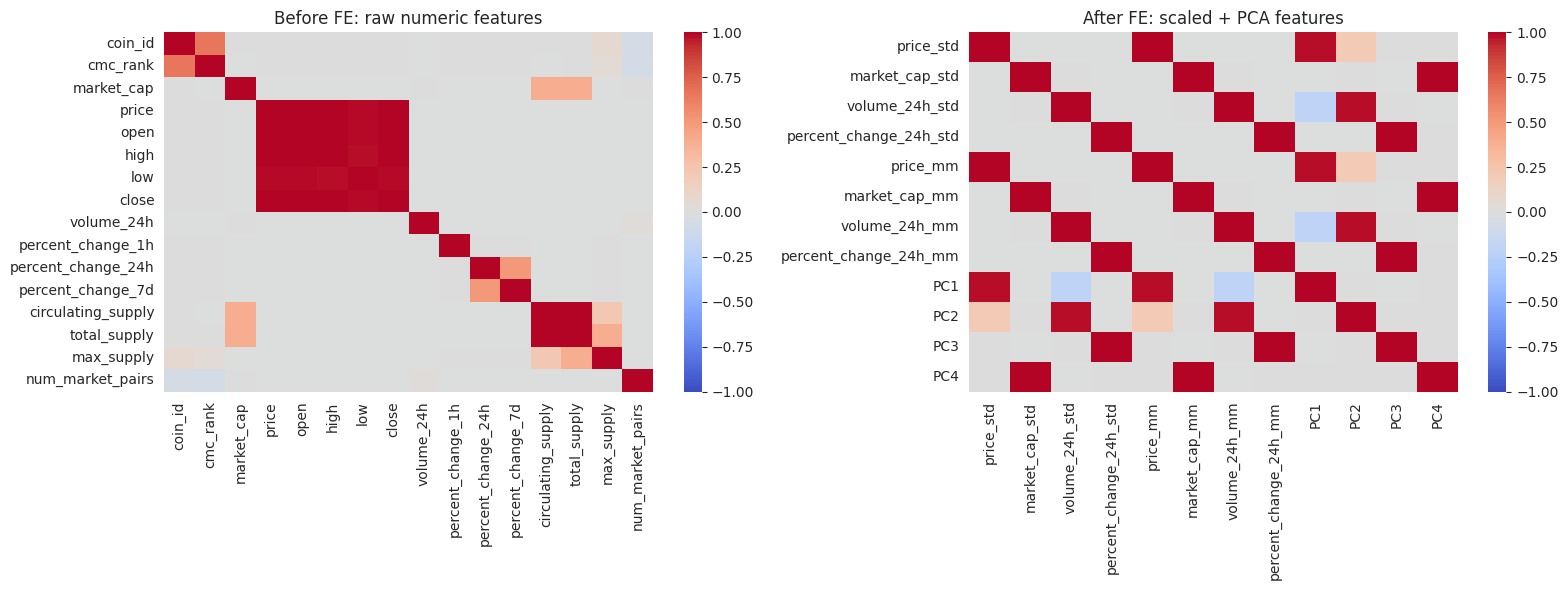

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load both datasets
raw = pd.read_csv(f"{DATA_INTERIM}/historical_clean.csv", parse_dates=["date"])
proc = pd.read_csv(f"{DATA_PROCESSED}/historical_proc.csv", parse_dates=["date"])

# 2) Select numeric columns (before) and features columns (after)
num_cols = raw.select_dtypes("number").columns
feat_cols = [c for c in proc.columns if c.endswith(("_std","_mm")) or c.startswith("PC")]

# 3) Compute correlations
corr_raw  = raw[num_cols].corr()
corr_proc = proc[feat_cols].corr()

# 4) Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(corr_raw,  ax=axes[0], cmap="coolwarm", vmin=-1, vmax=1)
axes[0].set_title("Before FE: raw numeric features")

sns.heatmap(corr_proc, ax=axes[1], cmap="coolwarm", vmin=-1, vmax=1)
axes[1].set_title("After FE: scaled + PCA features")

plt.tight_layout()
plt.show()